In [0]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 30kB/s 
     |████████████████████████████████| 512kB 48.0MB/s 
     |████████████████████████████████| 3.8MB 42.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d052951ae254c1d6615cd8ca67baeabada0325bc292bd411fdf727ed70dd7b6c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installatio

In [0]:
!pip install keract

In [0]:
import numpy as np
from keras import backend as K
from keras import applications
import matplotlib.pyplot as plt
from keras.models import load_model
from keract import get_activations, display_activations
import PIL.Image
import tensorflow as tf

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Normalize a tensor
def normalize(x):
    x = x/(K.sqrt(K.mean(K.square(x))) + K.epsilon())
    return x 

In [0]:
# Convert a tensor into a valid image
def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.1
    x = x - x.mean()
    x = x / (x.std() + K.epsilon())
    x = x * 0.1

    # clip to [0, 1]
    x = x +  0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x = x * 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def plot_images(img, clase ,scale = 1,pic_shape = (28,28,1)):
    if pic_shape[2] == 1:
        pic_shape = pic_shape[:2]
    fig = plt.figure(figsize=(1*scale,1*scale))  
    img = deprocess_image(img) 
    plt.title('Image that maximize class {}:'.format(clase), fontsize=16)
    plt.imshow(img.reshape(pic_shape))   

In [0]:
def generate_filter_image(input_img,layer_output,filter_index,channel=1,img_width=28,img_height=28):
    # we build a loss function that maximizes the activation of the nth filter of the layer considered
    loss = K.mean(layer_output[:,filter_index])
    #print(type(loss))
    #print(loss)
    # calculate the gradient of the loss evaluated at the provided image
    grads = K.gradients(loss, input_img)[0]
    #print(grads)
    # normalize the gradients, ensures a smooth gradient ascent process
    grads = normalize(grads)
    # function that takes the initial input image and gives the values of loss and gradients as outputs
    iterate = K.function([input_img], [loss, grads])
    #print(iterate)
    
    #start from a gray image with some noise
    input_img_data = np.random.random((1,img_width,img_height,channel))
    
    # Slowly upscaling towards the original size prevents a dominating high-frequency of the to visualized structure
    # as it would occur if we directly compute the 412d-image.
    # Behaves as a better starting point for each following dimension and therefore avoids poor local minima
    #upscaling_steps = 9
    n_iter = 30
    step = 1.
    
    for _ in range(n_iter):
        loss_value, grads_value = iterate([input_img_data])
        # update the image based on gradients
        input_img_data = input_img_data + grads_value * step 
    return input_img_data, loss_value


In [0]:
model = load_model('/content/drive/My Drive/Tesis maestria/Clasificacion-Mnist/cnn_mnist.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
input_img = model.layers[0].input
print(input_img)
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

Tensor("conv2d_3_input:0", shape=(?, 28, 28, 1), dtype=float32)


{'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7f0e763e5748>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x7f0e8352bf60>,
 'dense_3': <keras.layers.core.Dense at 0x7f0e76339ac8>,
 'dense_4': <keras.layers.core.Dense at 0x7f0e75199438>,
 'dropout_3': <keras.layers.core.Dropout at 0x7f0e76339f98>,
 'dropout_4': <keras.layers.core.Dropout at 0x7f0e7633d630>,
 'flatten_2': <keras.layers.core.Flatten at 0x7f0e8352be48>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7f0e7632c550>}

In [0]:
print(type(input_img)) 

<class 'tensorflow.python.framework.ops.Tensor'>


In [0]:
layer_output = layer_dict["dense_4"].output
layer_output

<tf.Tensor 'dense_4/Softmax:0' shape=(?, 10) dtype=float32>

In [0]:
out_index = [0,1,2,3,4,5,6,7,8,9]
#out_index = [0]

In [0]:
layer_output[:,out_index[0]].shape

TensorShape([Dimension(None)])

The total number of times the gradient ascent needs to run: 85
Probability of class 0:
 1.0
The total number of times the gradient ascent needs to run: 110
Probability of class 1:
 1.0
The total number of times the gradient ascent needs to run: 110
Probability of class 2:
 1.0
The total number of times the gradient ascent needs to run: 110
Probability of class 3:
 1.0
The total number of times the gradient ascent needs to run: 116
Probability of class 4:
 1.0
The total number of times the gradient ascent needs to run: 119
Probability of class 5:
 1.0
The total number of times the gradient ascent needs to run: 125
Probability of class 6:
 1.0
The total number of times the gradient ascent needs to run: 125
Probability of class 7:
 1.0
The total number of times the gradient ascent needs to run: 125
Probability of class 8:
 1.0
The total number of times the gradient ascent needs to run: 125
Probability of class 9:
 1.0


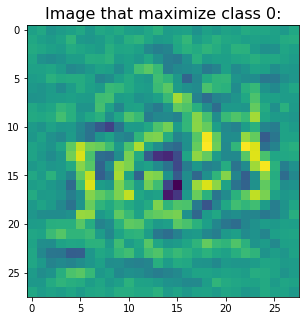

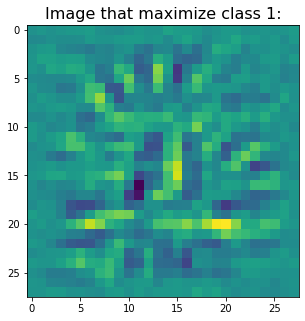

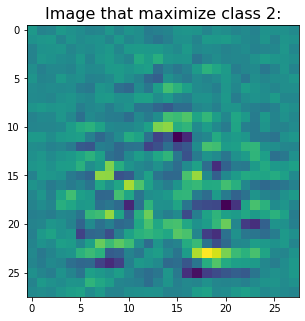

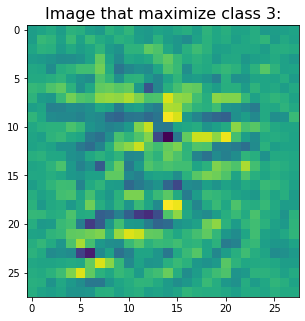

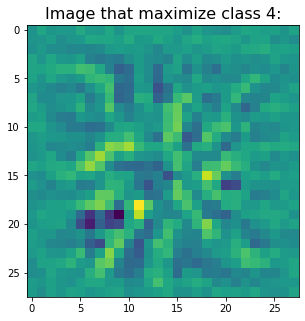

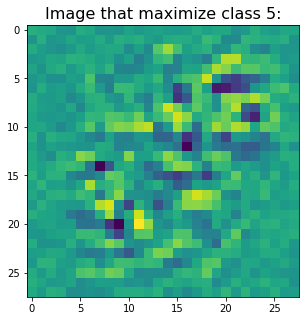

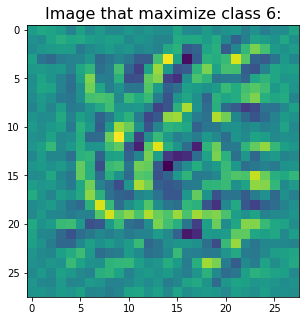

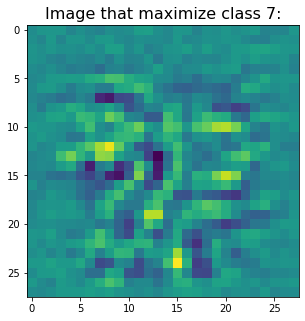

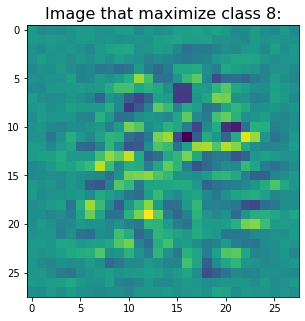

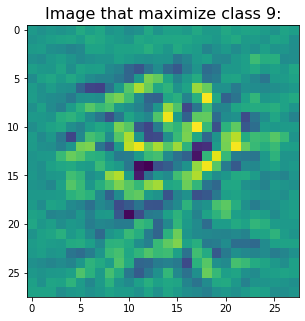

In [0]:
myprob = 0
n_alg = 1
#stop  = 2
stop  = 150
maximages =  {'Class':[],'Image':[]}

for i in range (0,len(out_index)):
    while(n_alg<stop):
        myimage, loss = generate_filter_image(input_img,layer_output,out_index[i])
        y_pred = model.predict(myimage)
        if np.nonzero(y_pred)[0].shape[0] == 1:
            if (np.nonzero(y_pred)[0]) == [out_index[i]]:
                myprob = y_pred[0][out_index[i]]
                break
            else:
                n_alg = n_alg + 1
        else:
            myprob = y_pred[0][out_index[i]]
            if  myprob >= 0.9:
                break
            else:
                n_alg = n_alg + 1
         
    if n_alg == stop:
        print('Sorry I can not find the image that maximize de class {}'.format(out_index[i]))
    else:
        print("The total number of times the gradient ascent needs to run: {}".format(n_alg))
        print("Probability of class {}:".format(out_index[i]))
        print("{:4.3}".format(myprob))
        plot_images(myimage, out_index[i] ,scale = 5 , pic_shape = (28,28,1))
        maximages['Class'].append(out_index[i])
        maximages['Image'].append(myimage)

In [0]:
for j in range(0,len(maximages['Class'])):
    activations = get_activations(model,maximages['Image'][j])
    display_activations(activations, save=False)